**Import the important modules**

In [2]:
!pip install tensorflow==2.2.0     

  Using cached https://files.pythonhosted.org/packages/af/50/d7da24189d95e2084bb1cc350a8e4acdf1b0c9b3d57def7a348f0d9cb062/tensorflow-2.2.0-cp37-cp37m-win_amd64.whl


In [1]:
import pandas as pd # for Dataframe.
import numpy as np # for array formation.
import pickle
import datetime # for datetime.
import string
import random as ran # for randomization
from random import randint
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg
import re # for regular expression
import nltk # for natural language processing
import tensorflow as tf # for tensorflow
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle #for randomization in data. 
from sklearn.model_selection import train_test_split #split the data 
from tensorflow.keras.applications.xception import Xception ,preprocess_input # use pre-trained xception model for image feature extraction.
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.text import Tokenizer# for tokenization of text data.
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding the text tokenize sequence.

ImportError: Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

**Let's import the data files**

In [25]:
path_of_image='/content/drive/My Drive/NLMCXR_png/'   # from this path we get our images.
test_input = np.load("/content/test_input.npy",allow_pickle=True)
test_output = np.load("/content/test_output.npy",allow_pickle=True)

**MAKE THE WORD EMBEDDINGS USING FATSTEXT PRE-TRAINED MODELS**

**tokenizer**

In [4]:
token = pickle.load(open("/content/tokenizer.pkl", 'rb'))
embedding_matrix = pickle.load(open("/content/embedding_matrix_oversample.pkl", 'rb'))
path= pickle.load(open("/content/path.pkl", 'rb'))

In [5]:
from google.colab import drive# import the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
maximum_length_output_sentences= 80 

In [7]:
SIZE_OF_BATCH=32 #Batch size
SIZE_OF_BUFFER= 500  #Batch Buffer
DIMENSION_OF_EMBEDDING= 300 #Embedding
UNITS= 300  #units

**Lets get encoder and decoder**

In [8]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Reshape, Concatenate
class encoder(tf.keras.Model):
  """ encoder for image features extracted by pre-trained model"""
  def __init__(self,DIMENSION_OF_EMBEDDING):
    super(encoder,self).__init__()
    self.flat=tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(DIMENSION_OF_EMBEDDING, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45),name='output_layer_of_encoder')# dense layer.
    
  def call(self, a):
    concatination_enc= Concatenate()([a[:,0], a[:,1]])# concatenate
    a=self.flat(concatination_enc)
    a =self.dense(a)
    return a

In [9]:
class decoder(tf.keras.Model):
  """ RNN decoder with attention over image features."""
  def __init__(self,  DIMENSION_OF_EMBEDDING, UNITS, size_of_vocabulary):
        super(decoder, self).__init__()
        self.units = UNITS
        self.concat = tf.keras.layers.Concatenate()
        self.embedding = tf.keras.layers.Embedding(size_of_vocabulary,DIMENSION_OF_EMBEDDING,weights=[embedding_matrix], input_length=maximum_length_output_sentences, trainable=False)
        self.lstm = tf.keras.layers.LSTM(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.dense = tf.keras.layers.Dense(size_of_vocabulary, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=45))
        self.attention = tf.keras.layers.AdditiveAttention(self.units)
        self.flatten = tf.keras.layers.Flatten()
  def call(self, a,features,hidden):
        attention_outputs = self.attention([features,hidden]) # attention have the encoder features and the hidden states
        embedding = self.embedding(a)# here we make the embedding of text
        concat_output = self.concat([embedding,tf.expand_dims(attention_outputs,1)])# here we concat the embedding and attention output
        output, prev_state_vector,_ = self.lstm(concat_output)# here we pass the concat output 
        a= self.flatten(output)
        a= self.dense(a)
        return a,prev_state_vector

**Extract the image features with the help of chexnet pre-trained model**

In [10]:
size_of_vocabulary=1445
Encoder= encoder(DIMENSION_OF_EMBEDDING) # encoder
Decoder= decoder(DIMENSION_OF_EMBEDDING, UNITS, size_of_vocabulary)# decoder
Encoder.built = True
Decoder.built = True
encod_temp = Encoder(np.random.rand(1,30,1024))
decod_temp = Decoder(np.random.rand(1,1),np.random.rand(1,300),np.random.rand(1,300))
Encoder.load_weights('/content/abhi_krishna_oversample_weights_encoder_final_final.h5')
Decoder.load_weights('/content/drive/MyDrive/abhi_krishna_oversample_weights_decoder_final.h5')

In [19]:
chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(299,299,3))
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
model.load_weights('/content/drive/MyDrive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
model = Model(inputs = model.input, outputs = model.layers[-2].output)
avg_pooling=tf.keras.layers.GlobalAveragePooling2D(data_format=None)(model.output)
model_for_image_features=Model(inputs=model.input,outputs=avg_pooling)

In [20]:
def tensor_of_image(path_of_image, name_of_image, model):
  """ Here we extract the features of the image"""
  i = tf.io.read_file(path_of_image + str(name_of_image)) # read file
  i = tf.image.decode_jpeg(i, channels=3) # decode the jpeg
  i = tf.image.resize(i, (299,299)) # resize the image
  i = tf.keras.applications.xception.preprocess_input(i) # extract the features with the help of xception model.
  features_of_the_image = model(tf.constant(i)[None, :]) # features of image.
  return features_of_the_image

In [37]:
def score(x):
    """cumulative score of the sentences"""
    return x[1]/len(x[0])

def FINAL_FUNCTION_1(name_of_image, beam_index=3):
    """take image as input in beam search"""
    figure, axis = plt.subplots(1,len(name_of_image), figsize= (10,10), tight_layout=True)
    count=0
    for image, subplot in zip(name_of_image, axis.flatten()):
      image_= mpimg.imread(path_of_image+image)
      imageplot = axis[count].imshow(image_, cmap ='bone')
      count +=1
    plt.show()
    hidden_1 =  tf.zeros((1, UNITS))# Initialize the hidden state
    tensor_of_im = tf.convert_to_tensor([tensor_of_image(path_of_image,path[0], model_for_image_features),# img[0],img[1] 
                                      tensor_of_image(path_of_image,path[1],  model_for_image_features)])
    features_of_image = tf.constant(tensor_of_im)[None, :]# get the features of the image
    values_of_features = Encoder(features_of_image)# get the encoder output
    start = [token.word_index["<start>"]] # here we get the start index
    word_decoder = [[start, 0.0]]
    while len(word_decoder[0][0]) < maximum_length_output_sentences:
        temp = []
        for s in word_decoder:
            predict,hidden_1 = Decoder(tf.cast(tf.expand_dims([s[0][-1]], 0), tf.float32), values_of_features, hidden_1) # het the output from the decoder
            word_preds = np.argsort(predict[0])[-beam_index:]# here we return the indices of the predictions
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]# here we get the next impresssiona and probability score
                next_cap.append(w)
                prob += predict[0][w]
                temp.append([next_cap, prob.numpy()])
        word_decoder = temp
        # Sorting according to the probabilities scores
        word_decoder = sorted(word_decoder, reverse=False, key=score)
        # Getting the top words
        word_decoder = word_decoder[-beam_index:]
    word_decoder = word_decoder[-1][0]
    impression = [token.index_word[i] for i in word_decoder if i !=0]
    result = []
    
    for i in impression:
        if i != '<end>':
            result.append(i)
        else:
            break
    text = ' '.join(result[1:])
    return result, text

In [39]:
def FINAL_FUNCTION_2(result,text,actual_text):
    reference = [actual_text.split()[1:-1]]
    result = result[:-1]
    print('='*50)
    print("Actual impression is:", actual_text)
    print("Predicted impression is :",text)
    print('*'*50)
    print('One-gram: {:.4f}  || Cumulative  one gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(1, 0, 0, 0)), sentence_bleu(reference, result, weights=(1, 0, 0, 0))))
    print('Two-gram: {:.4f}  || Cumulative  two gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 1, 0, 0)), sentence_bleu(reference, result, weights=(0.5, 0.5, 0, 0))))
    print('Three-gram: {:.4f}|| Cumulative  three gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 1, 0)), sentence_bleu(reference, result, weights=(0.33, 0.33, 0.33, 0))))
    print('Four-gram: {:.4f} || Cumulative four gram: {:.4f}'.format(sentence_bleu(reference, result, weights=(0, 0, 0, 1)), sentence_bleu(reference, result, weights=(0.25, 0.25, 0.25, 0.25))))

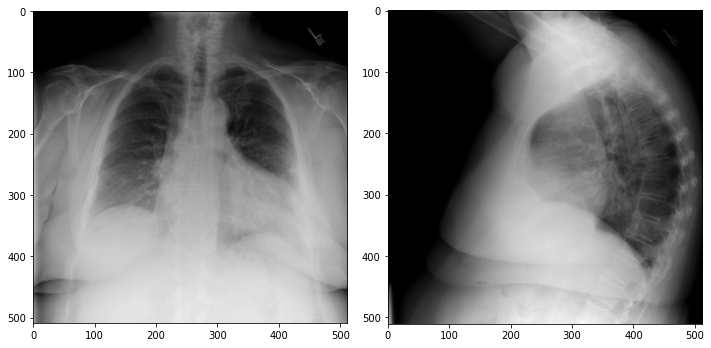

Actual impression is: <start> stable cardiomegaly clear lungs <end>
Predicted impression is : with clear infiltrate disease chest within
**************************************************
One-gram: 0.1667  || Cumulative  one gram: 0.1667
Two-gram: 1.0000  || Cumulative  two gram: 0.4082
Three-gram: 1.0000|| Cumulative  three gram: 0.5536
Four-gram: 1.0000 || Cumulative four gram: 0.6389


In [40]:
result,predicted_text= FINAL_FUNCTION_1(test_input[1])
actual = test_output[1]
FINAL_FUNCTION_2(result,predicted_text,actual)

In [2]:
import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.